In [100]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.linalg import eig

from hopfield_network import HopfieldNetwork, MishaHopfieldNetwork, hamming_distance, MishaHopfieldNetwork_v2

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
num_iterations = 20
num_neurons = 80
num_morphs = 30

x0 = (np.random.binomial(1, 0.5, num_neurons) - 0.5) * 2
x1 = (np.random.binomial(1, 0.5, num_neurons) - 0.5) * 2
x_init = np.array([x0, x1])

identical_inds = np.where(x0 == x1)[0]
different_inds = np.where(x0 != x1)[0]

random.shuffle(different_inds)
morph_inds = np.split(different_inds, np.sort(np.random.choice(len(different_inds), num_morphs, replace=False)))[1:]

x_morph = [x0]
for i in range(num_morphs):
    x_morph_temp = x_morph[-1].copy()
    x_morph_temp[morph_inds[i]] = -x_morph_temp[morph_inds[i]]
    x_morph.append(x_morph_temp)

x_morph = np.array(x_morph[1:])

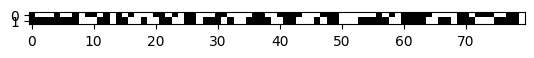

In [3]:
plt.imshow(x_init, "gray")

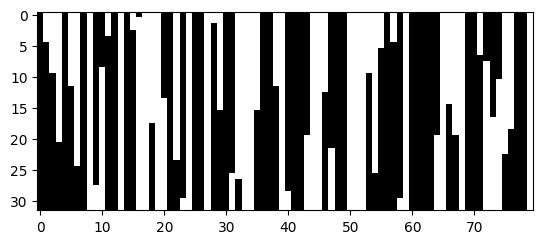

In [4]:
plt.imshow(np.concatenate([x0[None], x_morph, x1[None]]), "gray")

In [6]:
hn = HopfieldNetwork(num_neurons, synchronous=True, num_iter=20, threshold=0)

In [7]:
hn.train_weights(x_init)

In [8]:
test_x = np.array([x_morph[0], x_morph[-1]])

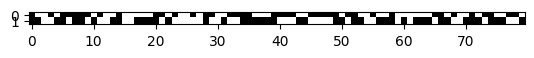

In [11]:
plt.imshow(x_init, "gray")

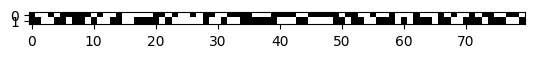

In [12]:
plt.imshow(test_x, "gray")

In [13]:
predict_x = hn.predict(test_x)

In [18]:
print(f"Differences between test and initial: {np.sum(test_x != x_init)}")
print(f"Differences between reconstructed and initial: {np.sum(predict_x != x_init)}")

Differences between test and initial: 2
Differences between reconstructed and initial: 0


In [21]:
for i in range(num_iterations):
    for j in range(num_morphs):
        hn.train_weights(x_morph[j][None])

In [35]:
predict_x = hn.predict(np.concatenate([x_init[0][None], x_morph, x_init[1][None]]))

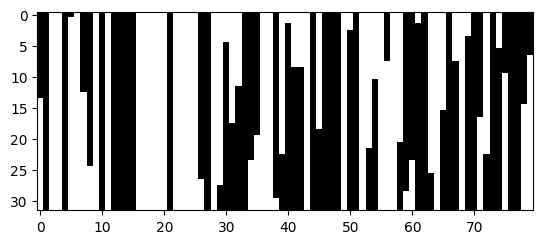

In [37]:
plt.imshow(np.concatenate([x_init[0][None], x_morph, x_init[1][None]]), "gray")

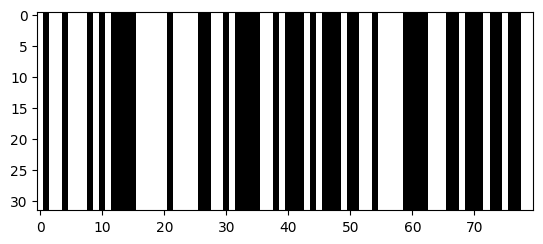

In [39]:
plt.imshow(predict_x, "gray")

In [43]:
print(f"Hamming distance from converged predictions given all test samples and the middle-level morphing sample: {np.sum(predict_x - x_morph[14])}")
print("Hence there is only one attractor")

Hamming distance from converged predictions given all test samples and the middle-level morphing sample: 0.0
Hence there is only one attractor


In [108]:
num_iterations = 20
num_neurons = 100
num_morphs = 30

x0 = (np.random.binomial(1, 0.5, num_neurons) - 0.5) * 2
x1 = (np.random.binomial(1, 0.5, num_neurons) - 0.5) * 2
x_init = np.array([x0, x1])

identical_inds = np.where(x0 == x1)[0]
different_inds = np.where(x0 != x1)[0]

random.shuffle(different_inds)
morph_inds = np.split(different_inds, np.sort(np.random.choice(len(different_inds), num_morphs, replace=False)))[1:]

x_morph = [x0]
for i in range(num_morphs):
    x_morph_temp = x_morph[-1].copy()
    x_morph_temp[morph_inds[i]] = -x_morph_temp[morph_inds[i]]
    x_morph.append(x_morph_temp)

x_morph = np.array(x_morph[1:])

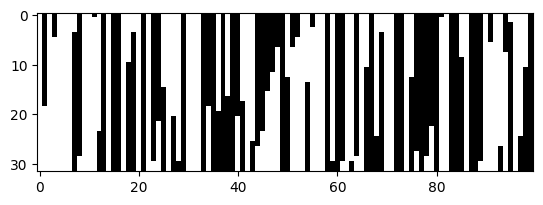

In [109]:
plt.imshow(np.concatenate([x0[None], x_morph, x1[None]]), "gray")

In [116]:
# gradual morphing

misha_hn = MishaHopfieldNetwork(num_neurons, synchronous=True, num_iter=20)

misha_hn.train_weights(x_init)

hamming_distance_init = hamming_distance(x_init[0], x_init[1])

w_morph = np.zeros((num_morphs, ))
eta = 0.5

converged_state = np.zeros((num_iterations, num_morphs, num_neurons))
correlations_gradual_morph = np.zeros((num_iterations, num_morphs))

for i in range(num_iterations):
    for j in range(num_morphs):
        x_one_step = misha_hn.one_step_dynamics(x_morph[j])
        hamming_distance_temp = hamming_distance(x_one_step, x_morph[j]) / hamming_distance_init
        w_morph[j] += eta * hamming_distance_temp
        misha_hn.train_weights(x_morph[j][None], w=w_morph[[j]])
    
    for j in range(num_morphs):
        converged_state[i, j, :], _ = misha_hn.forward(x_morph[j])
        correlations_gradual_morph[i, j] = np.sum(converged_state[i, j] * x_init[0]) / num_neurons

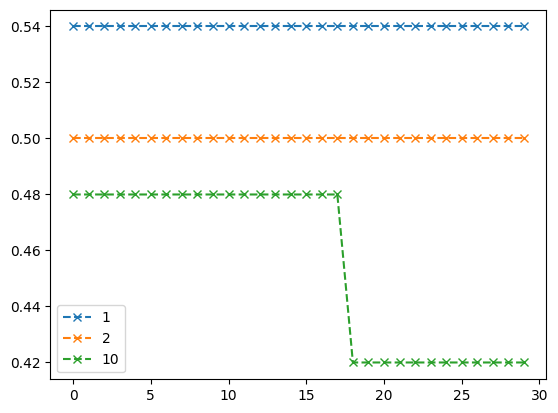

In [117]:
for i in [0, 1, 9]:
    plt.plot(correlations_gradual_morph[i, :], "x--", label=str(i+1))
plt.legend()

In [114]:
# random morphing

misha_hn = MishaHopfieldNetwork(num_neurons, synchronous=True, num_iter=20)

misha_hn.train_weights(x_init)

hamming_distance_init = hamming_distance(x_init[0], x_init[1])

w_morph = np.zeros((num_morphs, ))
eta = 0.5

converged_state = np.zeros((num_iterations, num_morphs, num_neurons))
correlations_gradual_morph = np.zeros((num_iterations, num_morphs))

num_converge_steps = np.zeros((num_iterations, num_morphs))

for i in range(num_iterations):
    random_permutation = np.random.permutation(np.arange(num_morphs))
    for j in range(num_morphs):
        x_one_step = misha_hn.one_step_dynamics(x_morph[random_permutation[j]])
        hamming_distance_temp = hamming_distance(x_one_step, x_morph[random_permutation[j]]) / hamming_distance_init
        w_morph[random_permutation[j]] += eta * hamming_distance_temp
        misha_hn.train_weights(x_morph[j][None], w=w_morph[[random_permutation[j]]])
    
    for j in range(num_morphs):
        converged_state[i, j, :], converge_its = misha_hn.forward(x_morph[j])
        correlations_gradual_morph[i, j] = np.sum(converged_state[i, j] * x_init[0]) / num_neurons
        num_converge_steps[i, j] = converge_its

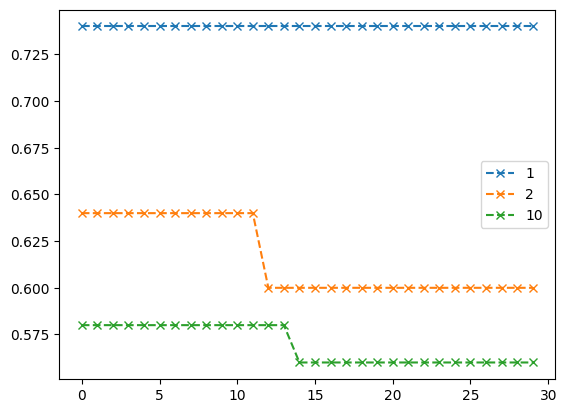

In [115]:
for i in [0, 1, 9]:
    plt.plot(correlations_gradual_morph[i, :], "x--", label=str(i+1))
plt.legend()

In [106]:
# testing v2 MishaHopfieldNetwork

# gradual morphing

misha_hn = MishaHopfieldNetwork_v2(num_neurons, synchronous=True, num_iter=20)

misha_hn.train_weights(x_init)

hamming_distance_init = hamming_distance(x_init[0], x_init[1])

w_morph = np.zeros((num_morphs, ))
eta = 0.5

converged_state = np.zeros((num_iterations, num_morphs, num_neurons))
correlations_gradual_morph = np.zeros((num_iterations, num_morphs))

for i in range(num_iterations):
    for j in range(num_morphs):
        x_one_step = misha_hn.one_step_dynamics(x_morph[j])
        hamming_distance_temp = hamming_distance(x_one_step, x_morph[j]) / hamming_distance_init
        w_morph[j] += eta * hamming_distance_temp
    misha_hn.train_weights(x_morph, w=w_morph)
    
    for j in range(num_morphs):
        converged_state[i, j, :], _ = misha_hn.forward(x_morph[j])
        correlations_gradual_morph[i, j] = np.sum(converged_state[i, j] * x_init[0]) / num_neurons

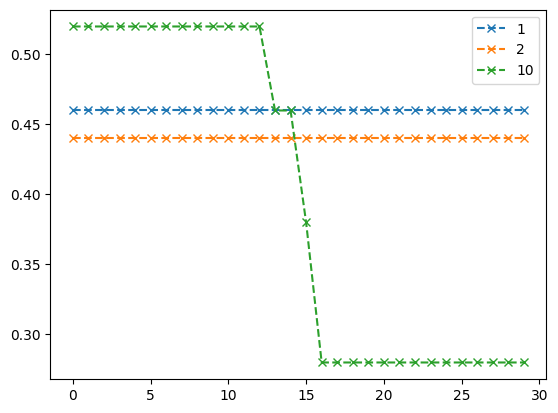

In [107]:
for i in [0, 1, 9]:
    plt.plot(correlations_gradual_morph[i, :], "x--", label=str(i+1))
plt.legend()